# Acessando as Pastas do Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# Imports

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from PIL import Image
import cv2
import os
import pandas as pd
from keras.regularizers import l2
from matplotlib import pyplot as plt

# Parametros


In [ ]:

# definir hiperparâmetros
batch_size = 32
num_classes = 1
epochs = 50

# Carregar dados de treinamento e teste

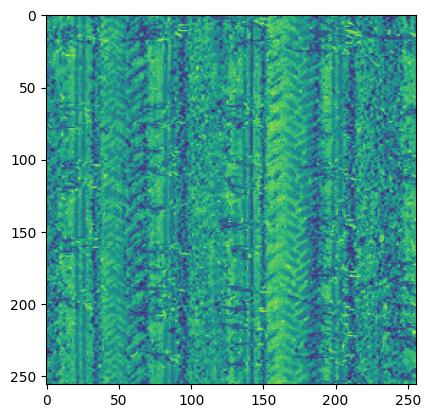

Shape do array de imagens:  (1000, 256, 256, 1)


In [ ]:
# Definir o caminho para o diretório com as imagens
diretorio_imagens = "/content/drive/MyDrive/TG/sorgo_256/20160613_F54_training_256x256"

# Inicializar o array para armazenar as imagens
X = np.zeros((1000, 256, 256, 1))

# Loop para percorrer as imagens no diretório e carregá-las no array
for i, nome_arquivo in enumerate(os.listdir(diretorio_imagens)):
    if i>= 1000:
        break
    else:
        caminho_arquivo = os.path.join(diretorio_imagens, nome_arquivo)
        imagem = cv2.imread(caminho_arquivo)
        imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY).reshape(256, 256, 1)
        X[i] = imagem

# Exibir o shape do array de imagens
plt.imshow(X[0])
plt.show()
X = X/255
print("Shape do array de imagens: ", X.shape)

In [ ]:
Y = pd.read_csv("/content/drive/MyDrive/TG/sorgo_256/training_gt.csv")
Y = Y['count'].head(1000)
print(Y.mean())
Y = Y.fillna(Y.mean())
max_Y = np.amax(Y)
Y = Y/np.amax(Y)
print('Quantidade de NaN em Y: ', Y.isna().sum())
Y

48.196
Quantidade de NaN em Y:  0


0      0.385185
1      0.518519
2      0.311111
3      0.629630
4      0.370370
         ...   
995    0.385185
996    0.400000
997    0.451852
998    0.644444
999    0.496296
Name: count, Length: 1000, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Estrutura da CNN

In [ ]:
adam = Adam(learning_rate=0.001, )

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

In [ ]:
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_absolute_error'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/10
25/25 [==============================] - 125s 5s/step - loss: 110.7527 - mean_absolute_error: 3.3654 - val_loss: 17.6828 - val_mean_absolute_error: 0.2133
Epoch 2/10
25/25 [==============================] - 119s 5s/step - loss: 16.4802 - mean_absolute_error: 0.1693 - val_loss: 15.2357 - val_mean_absolute_error: 0.4939
Epoch 3/10
25/25 [==============================] - 117s 5s/step - loss: 13.7356 - mean_absolute_error: 0.1792 - val_loss: 12.5500 - val_mean_absolute_error: 0.3442
Epoch 4/10
25/25 [==============================] - 118s 5s/step - loss: 11.4990 - mean_absolute_error: 0.2098 - val_loss: 10.5956 - val_mean_absolute_error: 0.3456
Epoch 5/10
25/25 [==============================] - 118s 5s/step - loss: 9.6915 - mean_absolute_error: 0.1530 - val_loss: 8.9734 - val_mean_absolute_error: 0.2853
Epoch 6/10
25/25 [==============================] - 139s 6s/step - loss: 8.2698 - mean_absolute_error: 0.1492 - val_loss: 7.6938 - val_mean_absolute_error: 0.2630
Epoch 7/10
25

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: [4.35157585144043, 0.21654774248600006]


In [ ]:
predictions = model.predict(X_test)
predictions_original = predictions * max_Y
y_test_original = y_test * max_Y
predictions_original = np.round(predictions_original)
df_dict = {'Previsões': predictions_original[:, 0], 'Ground-Truth': y_test_original}
df = pd.DataFrame(df_dict)
df

7/7 [==============================] - 7s 939ms/step


,Previsões,Ground-Truth
521,20.0,24.0
737,18.0,28.0
740,19.0,38.0
660,18.0,26.0
411,21.0,57.0
...,...,...
408,20.0,77.0
332,21.0,31.0
208,17.0,53.0
613,23.0,89.0
